# My Solution

In [32]:
from skimage import io,color
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import eye, diags, kron
from scipy.sparse.linalg import cg
from skimage import img_as_float32
from skimage import io
from skimage.util import img_as_ubyte

bear_img_path = "bear.jpg"
plane_img_path = "plane.jpg"
water_img_path = "water.jpg"
bird_img_path = "bird.jpg"

## 1 Laplace Operator

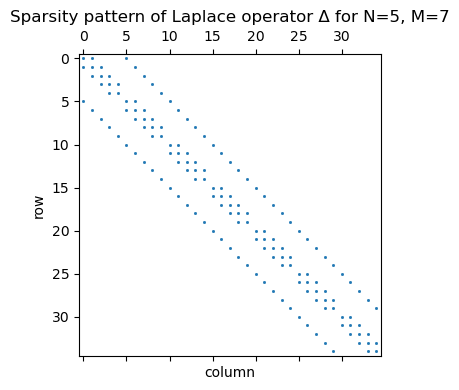

In [33]:
def laplace_operator(N: int, M: int):

    # 1D discrete second derivative (tridiagonal) along vertical direction
    D2_N = diags([1, -2, 1], offsets=[-1, 0, 1], shape=(N, N), dtype=float)

    # 1D discrete second derivative (tridiagonal) along horizontal direction
    D2_M = diags([1, -2, 1], offsets=[-1, 0, 1], shape=(M, M), dtype=float)

    # Identity matrices for Kronecker product combination
    I_N = eye(N, format="csr", dtype=float)
    I_M = eye(M, format="csr", dtype=float)

    # Build 2D Laplacian using Kronecker sum: Δ = I_M ⊗ D2_N + D2_M ⊗ I_N
    Delta = kron(I_M, D2_N, format="csr") + kron(D2_M, I_N, format="csr")
    return Delta

# die Matrix für (N,M) = (5,7) graphisch darstellen
L = laplace_operator(5, 7)
plt.figure(figsize=(5, 4))
plt.spy(L, markersize=1)
plt.title("Sparsity pattern of Laplace operator Δ for N=5, M=7")
plt.xlabel("column")
plt.ylabel("row")
plt.tight_layout()
plt.show()

## 2 Seamless-Cloning mit Hilfe der Differenzengleichung

What does the image dimension (`ndim`) mean?

`img.ndim` indicates the number of array dimensions (number of axes):

| Image Type             | Array Shape     | ndim | Explanation |
|------------------------|-----------------|------|-------------|
| Grayscale Image        | (H, W)          | 2    | Each pixel has only **one value** |
| RGB Color Image        | (H, W, 3)       | 3    | Each pixel has **3 channels** (R, G, B) |
| RGBA Image             | (H, W, 4)       | 3    | Each pixel has **4 channels** (including Alpha for transparency) |
| Other formats (e.g. batch) | (N, H, W, C) | 4    | Multiple images or an extra dimension for batch processing |


In [34]:
def load_img_grey(img_path: str):
    # for CG, Laplace computing
    # the return value of unit8 is 0-255
    # because the CG methodes returns value of type = float
    # we need to constraint data type
    # because the picture here is small
    # using float32 is enough
    img_dt = io.imread(img_path)
    if img_dt.ndim == 3 :
        img_dt = color.rgb2gray(img_dt)
    img_dt = img_as_float32(img_dt)    
    img_dt = np.clip(img_dt, 0.0, 1.0)
    return img_dt

def seamless_cloning_task2(f_star_patch, g_patch):
    N,M = g_patch.shape
    Delta = laplace_operator(N,M)
    vec_g = g_patch.flatten()
    b = Delta @ vec_g
    # to solve delat @ vec(h) = b
    vec_h, info = cg(Delta,b,maxiter=2000, tol=1e-6)

    # about info:
    # 0 : successful exit
    # >0 : convergence to tolerance not achieved, 
    # number of iterations
    if info != 0:
        print(f"[Warn] CG did not converge normally (info={info}). You may need to increase maxiter or check the data.")
    
    # vec_h is a vector, we need to transform it into a N*M matrix
    h = vec_h.reshape(N,M)

    # It is like getting the margin of the picture, or getting x
    # xxxxxx
    # xoooox
    # xoooox
    # xoooox
    # xxxxxx
    h[0, :]  = f_star_patch[0, :]
    h[-1, :] = f_star_patch[-1, :]
    h[:, 0]  = f_star_patch[:, 0]
    h[:, -1] = f_star_patch[:, -1]    

    # to insure that the value is in the range [0,1]
    h = np.clip(h, 0.0, 1.0)

    return h

## 3 Seamless-Cloning gemischte Gradientem

In [35]:
# Task 3
def grad_forward(u):
    # Initialize gradient arrays with zeros, same shape as u
    gx = np.zeros_like(u, dtype=np.float64)
    gy = np.zeros_like(u, dtype=np.float64)

    # Compute forward differences:
    # gx for vertical direction (difference between consecutive rows)
    gx[:-1, :] = u[1:, :] - u[:-1, :]

    # gy for horizontal direction (difference between consecutive columns)
    gy[:, :-1] = u[:, 1:] - u[:, :-1]
    return gx, gy

def divergence_backward(vx, vy):
    # Grid size
    N, M = vx.shape
    divv = np.zeros((N, M), dtype=np.float64) # Initialize divergence field
    # Backward difference in x-direction (vertical)
    divv[1:, :] += (vx[1:, :] - vx[:-1, :])
    divv[0,  :] += vx[0, :]

    # Backward difference in y-direction (horizontal)
    divv[:, 1:] += (vy[:, 1:] - vy[:, :-1])
    divv[:, 0 ] += vy[:, 0]
    return divv

def seamless_clone_mixed_gray(f_star, g, top_left):
    i0, j0 = top_left
    N, M = g.shape
    f_patch = f_star[i0:i0+N, j0:j0+M].astype(np.float64)
    g      = g.astype(np.float64)

    # 1) Compute mixed gradient field v = (v_x, v_y)
    g_x,  g_y  = grad_forward(g)
    fs_x, fs_y = grad_forward(f_patch)
    mag_g  = np.hypot(g_x,  g_y)
    mag_fs = np.hypot(fs_x, fs_y)
    use_fs = (mag_fs > mag_g)
    v_x = np.where(use_fs, fs_x, g_x)
    v_y = np.where(use_fs, fs_y, g_y)

    # 2) Compute divergence of v using backward finite differences
    divv = divergence_backward(v_x, v_y)

    # 3) If patch too small, fall back to naive copy
    if N < 3 or M < 3:
        out = f_star.copy()
        out[i0:i0+N, j0:j0+M] = g
        return out.astype(f_star.dtype)

    # Helper: map (i, j) → interior row index (column-major)
    def row_of(i, j):
        return (i - 1) + (j - 1) * (N - 2)

    # Generate indices for interior pixels (excluding 1-pixel boundary)
    interior_ids = []
    for j in range(1, M-1):
        for i in range(1, N-1):
            interior_ids.append(i + j * N)  # Column-major

    # Build Laplace operator and extract interior submatrix
    Delta = laplace_operator(N, M).tocsr()
    A_int = Delta[interior_ids, :][:, interior_ids]

    # 4) Prepare right-hand side b_int = (div v) + boundary terms
    b_full = divv.flatten(order="F")  # 明确列主序展开
    # 注意：上面的 Delta 是按列主序构造的；这里也用 F 展开保证一致
    b_int = b_full[[i + j * N for j in range(1, M-1) for i in range(1, N-1)]].astype(np.float64)

    # Add contributions from fixed boundary pixels (Dirichlet boundary)
    for j in range(1, M-1):
        for i in range(1, N-1):
            r = row_of(i, j)
            if i-1 == 0:     b_int[r] -= f_patch[i-1, j]  # Top
            if i+1 == N-1:   b_int[r] -= f_patch[i+1, j]  # Bottom
            if j-1 == 0:     b_int[r] -= f_patch[i, j-1]  # Left
            if j+1 == M-1:   b_int[r] -= f_patch[i, j+1]  # Right

    # 5) Solve the interior system A_int * h_int = b_int using Conjugate Gradient
    h_int_vec, info = cg(A_int, b_int, maxiter=2000, atol=0, tol=1e-6)
    if info != 0:
        print(f"[warn] CG (interior) not fully converged, info={info}")

    # 6) Reconstruct the full patch (use background for boundary)
    h = f_patch.copy()
    for j in range(1, M-1):
        for i in range(1, N-1):
            h[i, j] = h_int_vec[row_of(i, j)]

     # 7) Insert blended patch back into target and clamp to [0, 255]
    out = f_star.copy().astype(np.float64)
    out[i0:i0+N, j0:j0+M] = np.clip(np.rint(h), 0, 255)
    return out.astype(f_star.dtype)

def seamless_clone_mixed_color(f_star_rgb, g_rgb, top_left):
    # Copy background image to avoid modifying input
    out = f_star_rgb.copy()
    # Process each color channel
    for c in range(3):
        out[..., c] = seamless_clone_mixed_gray(out[..., c], g_rgb[..., c], top_left)
    return out


## 4 Bären und Flugzeug schneiden

#### Baeren ausscheiden mit Laplance-Operator

/var/folders/kw/qrl_mkc50r98y8l95mp8w2g00000gn/T/ipykernel_9119/2373619806.py:21: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  vec_h, info = cg(Delta,b,maxiter=2000, tol=1e-6)


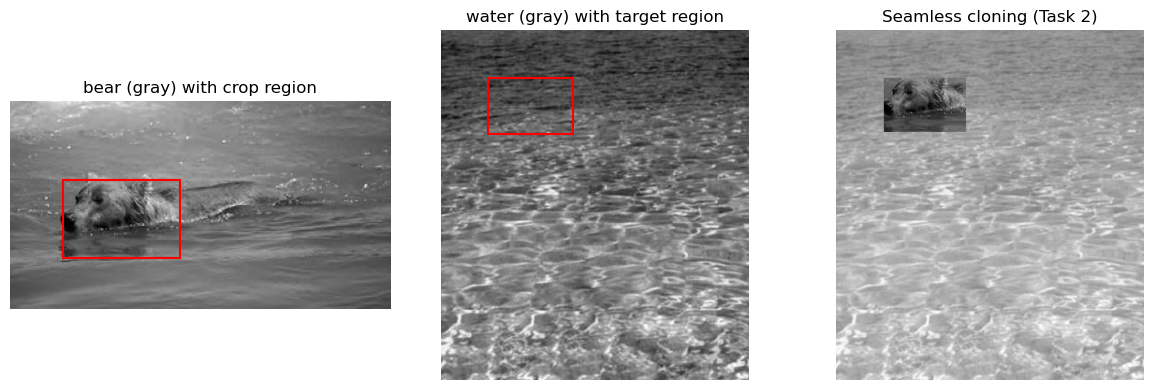

In [36]:
def visualize_task4_baer_mit_laplace():
    # position in f*, where the g will be added
    pi, pj = 50, 50
    # g is rectangular: size of the cut
    cut_h, cut_w = 60, 90
    # you can also use absolute coordinates to cut
    use_center_cut = False
    cut_top, cut_left = 60, 40  # only used when use_center_cut = False

    bear_grey = load_img_grey(bear_img_path)
    water_grey = load_img_grey(water_img_path)

    height_bear, width_bear = bear_grey.shape
    height_water, width_water = water_grey.shape

    # cut a piece from bear
    if use_center_cut:
        top = max(0, (height_bear - cut_h) // 2)
        left = max(0, (width_bear - cut_w) // 2)
        Ng, Mg = cut_h, cut_w
    else:
        # keep the cut window inside the bear image
        top = np.clip(cut_top, 0, max(0, height_bear - cut_h))
        left = np.clip(cut_left, 0, max(0, width_bear - cut_w))
        Ng, Mg = cut_h, cut_w

    bottom = min(height_bear, top + Ng)
    right  = min(width_bear, left + Mg)

    g = bear_grey[top:bottom, left:right]
    Ng, Mg = g.shape  # refresh in case border trimmed

    # ensure paste region fits inside water
    max_h = max(0, height_water - pi)
    max_w = max(0, width_water - pj)
    if Ng > max_h or Mg > max_w:
        Ng_new = min(Ng, max_h)
        Mg_new = min(Mg, max_w)
        print(f"[Warn] Patch exceeds background; cropped to {Ng_new} x {Mg_new}.")
        g = g[:Ng_new, :Mg_new]
        Ng, Mg = g.shape

    # get the background patch FROM WATER (fix)
    f_star_patch = water_grey[pi:pi+Ng, pj:pj+Mg]

    # solve Poisson (Task 2 solver assumed to exist)
    h = seamless_cloning_task2(f_star_patch, g)

    # compose result
    result = water_grey.copy()
    result[pi:pi+Ng, pj:pj+Mg] = h

    # visualize
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Fig 1: bear + red box (cropping region)
    axes[0].imshow(bear_grey, cmap="gray")
    axes[0].add_patch(plt.Rectangle(
        (left, top),
        Mg, Ng,           # width, height
        fill=False, ec='red', lw=1.5
    ))
    axes[0].set_title("bear (gray) with crop region")
    axes[0].axis("off")

    # Fig 2: water + red box (target paste region)
    axes[1].imshow(water_grey, cmap="gray")
    axes[1].add_patch(plt.Rectangle(
        (pj, pi),         # use pj, pi (fix variable names)
        Mg, Ng,
        fill=False, ec='red', lw=1.5
    ))
    axes[1].set_title("water (gray) with target region")
    axes[1].axis("off")

    # Fig 3: blending result
    axes[2].imshow(result, cmap="gray")
    axes[2].set_title("Seamless cloning (Task 2)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# run
visualize_task4_baer_mit_laplace()


#### Baeren ausscheiden mit gemischtem Gradienten und ohne Seamless-Cloning

/var/folders/kw/qrl_mkc50r98y8l95mp8w2g00000gn/T/ipykernel_9119/3288263072.py:81: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  h_int_vec, info = cg(A_int, b_int, maxiter=2000, atol=0, tol=1e-6)


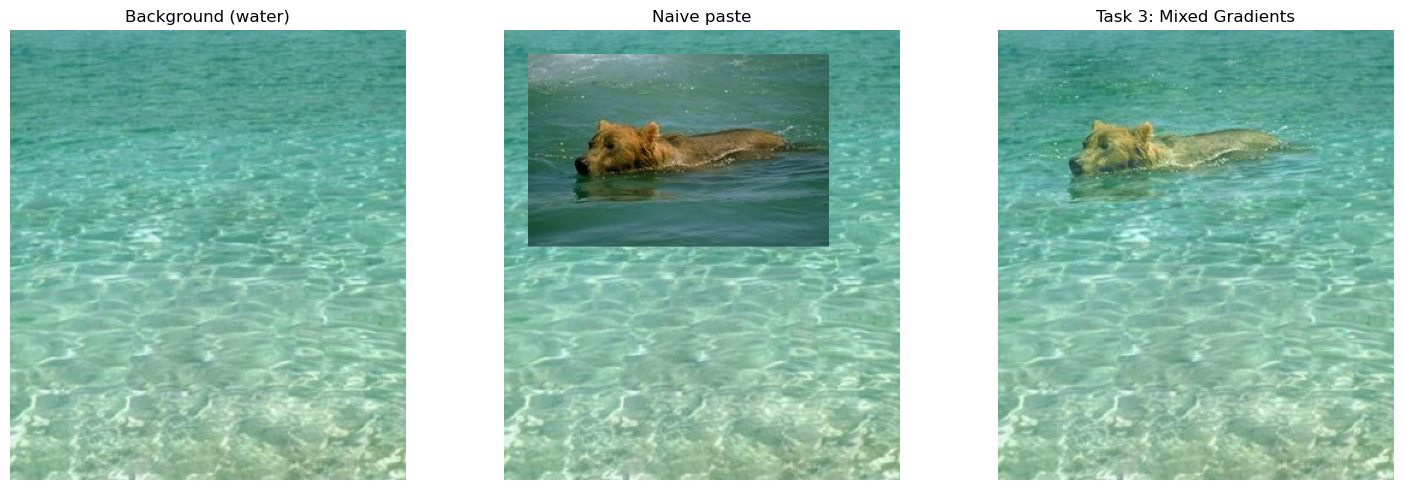

In [37]:
def visualize_task4_baer_gemischt_gradient_und_ohne_seamless_cloning():
    # -----------------------------
    # Adjustable parameters: cropping and pasting
    # -----------------------------
    # Rectangle to crop from the bear image:
    # top-left corner (crop_top, crop_left), with height and width (crop_h, crop_w)
    crop_top, crop_left = 0, 0     #  Adjust as needed
    crop_h,   crop_w    = 250, 250    # Adjust as needed

    # # Position to paste onto the f star image: top-left corner (i0, j0)
    i0, j0 = 20, 20                  #  Adjust as needed
    
    # Read the image as uint8 (if it's a float image, 
    # it will be converted back to the 0..255 range)
    bear  = img_as_ubyte(io.imread(bear_img_path))
    water = img_as_ubyte(io.imread(water_img_path))

    # If the image is grayscale, expand it to 3 channels for consistent processing
    if bear.ndim == 2:  bear  = np.stack([bear]*3, axis=-1)
    if water.ndim == 2: water = np.stack([water]*3, axis=-1)

    Hb, Wb, _ = bear.shape
    Hw, Ww, _ = water.shape

    # Ensure that the cropping window lies within the image
    crop_h = min(crop_h, Hb - crop_top)
    crop_w = min(crop_w, Wb - crop_left)
    g_rgb = bear[crop_top:crop_top+crop_h, crop_left:crop_left+crop_w, :]

    # Ensure that the paste region lies within the water image
    assert i0 >= 0 and j0 >= 0 and i0 + crop_h <= Hw and j0 + crop_w <= Ww, \
        "The paste region exceeds the bounds of the water image. Please adjust i0, j0 or the crop size."

    # Task 3
    out_rgb = seamless_clone_mixed_color(water, g_rgb, (i0, j0))

    # Visualization: original water image, direct paste, Task 3 result
    naive = water.copy()
    naive[i0:i0+crop_h, j0:j0+crop_w, :] = g_rgb

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(water); axs[0].set_title("Background (water)"); axs[0].axis("off")
    axs[1].imshow(naive); axs[1].set_title("Naive paste"); axs[1].axis("off")
    axs[2].imshow(out_rgb); axs[2].set_title("Task 3: Mixed Gradients"); axs[2].axis("off")
    plt.tight_layout()
    plt.show()

    # save result
    # io.imsave("task3_mixed_result.png", out_rgb)
    # print("Saved → task3_mixed_result.png")
    
visualize_task4_baer_gemischt_gradient_und_ohne_seamless_cloning()


#### Flugzeug ausscheiden mit Laplance-Operator

/var/folders/kw/qrl_mkc50r98y8l95mp8w2g00000gn/T/ipykernel_9119/2373619806.py:21: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  vec_h, info = cg(Delta,b,maxiter=2000, tol=1e-6)


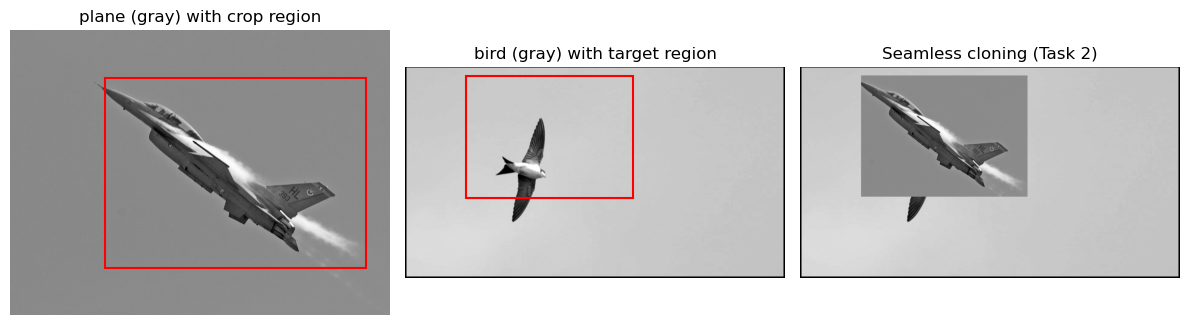

In [38]:
def visualize_task4_plane_mit_laplace():
    # position in f*, where g will be added
    pi, pj = 30, 200

    # cut size for the source patch
    cut_h, cut_w = 400, 550

    # absolute crop position in source (used if use_center_cut=False)
    use_center_cut = False
    cut_top, cut_left = 100, 200

    # Load source and background (names adjusted to your paths)
    # Source: plane image; Background: bird image
    bear_grey  = load_img_grey(plane_img_path)  # source
    water_grey = load_img_grey(bird_img_path)   # background

    height_bear,  width_bear  = bear_grey.shape
    height_water, width_water = water_grey.shape

    # Compute crop window in the source
    if use_center_cut:
        top  = max(0, (height_bear - cut_h) // 2)
        left = max(0, (width_bear  - cut_w) // 2)
    else:
        # keep crop fully inside source
        top  = int(np.clip(cut_top,  0, max(0, height_bear - cut_h)))
        left = int(np.clip(cut_left, 0, max(0, width_bear  - cut_w)))

    bottom = min(height_bear, top  + cut_h)
    right  = min(width_bear,  left + cut_w)

    # Extract source patch g
    g = bear_grey[top:bottom, left:right]
    Ng, Mg = g.shape  # actual patch size

    # Ensure paste region fits background; crop g if needed
    max_h = max(0, height_water - pi)
    max_w = max(0, width_water  - pj)
    if Ng > max_h or Mg > max_w:
        Ng_new = min(Ng, max_h)
        Mg_new = min(Mg, max_w)
        print(f"[Warn] Patch exceeds background; cropped to {Ng_new} x {Mg_new}.")
        g = g[:Ng_new, :Mg_new]
        Ng, Mg = g.shape

    # --- FIX 1: take background patch from water_grey (the background), not bear_grey ---
    f_star_patch = water_grey[pi:pi+Ng, pj:pj+Mg]

    # Solve Poisson (Task 2)
    h = seamless_cloning_task2(f_star_patch, g)

    # Compose into background
    result = water_grey.copy()
    result[pi:pi+Ng, pj:pj+Mg] = h

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Fig 1: source (plane) + crop box
    axes[0].imshow(bear_grey, cmap="gray")
    axes[0].add_patch(plt.Rectangle(
        (left, top),
        Mg, Ng,
        fill=False, ec='red', lw=1.5
    ))
    axes[0].set_title("plane (gray) with crop region")
    axes[0].axis("off")

    # Fig 2: background (bird) + target paste box
    axes[1].imshow(water_grey, cmap="gray")
    # --- FIX 2: use (pj, pi), not (j0, i0) ---
    axes[1].add_patch(plt.Rectangle(
        (pj, pi),
        Mg, Ng,
        fill=False, ec='red', lw=1.5
    ))
    axes[1].set_title("bird (gray) with target region")
    axes[1].axis("off")

    # Fig 3: result
    axes[2].imshow(result, cmap="gray")
    axes[2].set_title("Seamless cloning (Task 2)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# run
visualize_task4_plane_mit_laplace()


#### Flugzeut ausscheiden mit gemischtem Gradienten und ohne Seamless-Cloning

/var/folders/kw/qrl_mkc50r98y8l95mp8w2g00000gn/T/ipykernel_9119/3288263072.py:81: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  h_int_vec, info = cg(A_int, b_int, maxiter=2000, atol=0, tol=1e-6)


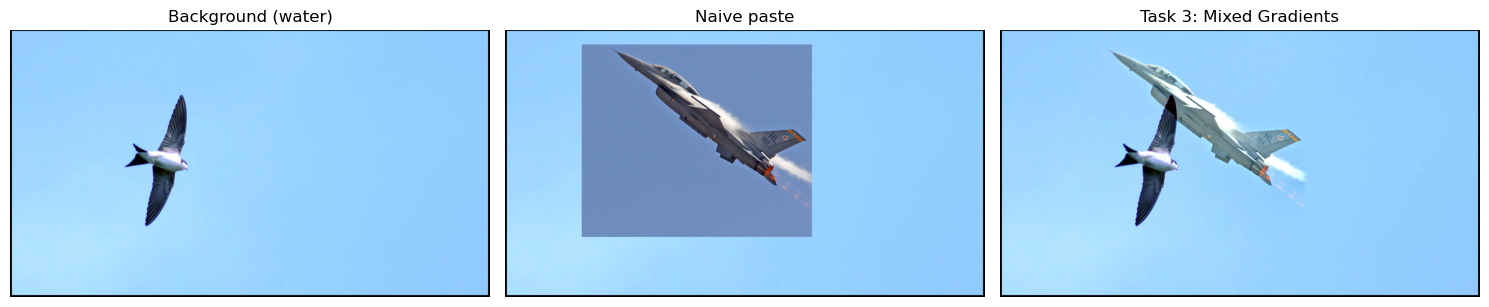

In [39]:
def visualize_task4_plane_gemischt_gradient_und_ohne_seamless_cloning():
    # -----------------------------
    # 2) Adjustable parameters: cropping and pasting
    # -----------------------------
    # Rectangle to crop from the bear image:
    # top-left corner (crop_top, crop_left), with height and width (crop_h, crop_w)
    crop_top, crop_left = 100, 100     # ← Adjust as needed
    crop_h,   crop_w    = 600, 600   # ← Adjust as needed

    # # Position to paste onto the f star image: top-left corner (i0, j0)
    i0, j0 = 40, 200       # ← Adjust as needed           
    
    # Read the image as uint8 (if it's a float image, 
    # it will be converted back to the 0..255 range)
    bear  = img_as_ubyte(io.imread(plane_img_path))
    water = img_as_ubyte(io.imread(bird_img_path))

    # If the image is grayscale, expand it to 3 channels for consistent processing
    if bear.ndim == 2:  bear  = np.stack([bear]*3, axis=-1)
    if water.ndim == 2: water = np.stack([water]*3, axis=-1)

    Hb, Wb, _ = bear.shape
    Hw, Ww, _ = water.shape

    # Ensure that the cropping window lies within the image
    crop_h = min(crop_h, Hb - crop_top)
    crop_w = min(crop_w, Wb - crop_left)
    g_rgb = bear[crop_top:crop_top+crop_h, crop_left:crop_left+crop_w, :]

    # Ensure that the paste region lies within the water image
    assert i0 >= 0 and j0 >= 0 and i0 + crop_h <= Hw and j0 + crop_w <= Ww, \
        "贴入区域超出 water 图像范围，请调整 i0,j0 或裁剪大小。"

    # Task 3 无缝克隆
    out_rgb = seamless_clone_mixed_color(water, g_rgb, (i0, j0))

    # Visualization: original water image, direct paste, Task 3 result
    naive = water.copy()
    naive[i0:i0+crop_h, j0:j0+crop_w, :] = g_rgb

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(water); axs[0].set_title("Background (water)"); axs[0].axis("off")
    axs[1].imshow(naive); axs[1].set_title("Naive paste"); axs[1].axis("off")
    axs[2].imshow(out_rgb); axs[2].set_title("Task 3: Mixed Gradients"); axs[2].axis("off")
    plt.tight_layout()
    plt.show()

    # io.imsave("task3_mixed_result.png", out_rgb)
    # print("Saved → task3_mixed_result.png")
    
visualize_task4_plane_gemischt_gradient_und_ohne_seamless_cloning()